# Gun Detection with VGG16

This notebook demonstrates how to detecting guns appearing in images or video, using the pre-trained VGG16 deep learning model.

To get started, you must have the following requirements installed:

1. tensorflow - to preprocess data and work with the VGG16 model
2. numpy - to prepare data during testing
3. matplotlib - to display images in the Jupyter notebook
4. notebook - to run this notebook in a Jupyter server

It is recommended to have a virtual environment to isolate these requirements from the rest of your system. This can be done using Python's virtualenv package.

First, open a Terminal (Command Prompt on Windows) in the same folder as this notebook and create a virtual environment:

```shell
python3 -m venv env
```

Next, activate the virtual environment. For Windows users:

```shell
.\env\Scripts\activate
```

For Linux and MacOS users:

```shell
source env/bin/activate
```

Now you can safely install the above requirements in your virtual environment:

```shell
pip install tensorflow numpy matplotlib notebook
```

After installation is complete, launch the Jupyter server to edit this notebook:

```shell
jupyter notebook
```

## Getting Started

The following imports are necessary to work with this notebook:

In [8]:
# General imports

import os
import numpy as np
from glob import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Tensorflow and Keras imports

from tensorflow import keras
from keras.models import Model
from keras.utils import load_img
from keras.models import load_model
from keras.models import Sequential
from keras.applications.vgg16 import VGG16
from keras.preprocessing.image import img_to_array
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Input, Lambda, Dense, Flatten, GlobalAveragePooling2D, Dropout

Just like in the previous example, we will be performing **transfer learning** with the **VGG16** pre-trained model from **Keras Applications**.

## The Dataset

For this scenario, we will be using a custom dataset of gun images, derived from multiple sources on the Internet.

The images in the dataset have a **high level of variety and diversity**. This ensures that the model can generalize better to locate and identify guns when operationalized in a real-world scenario.

### Exploratory Data Analysis

First, we'll inspect how the dataset is structured.

In [3]:
!tree "./data" -d

./data
├── train
│   ├── gun
│   └── nogun
└── validation
    ├── gun
    └── no gun

6 directories


As shown above, the dataset has been divided into 2 sub-directories:

1. `train` - training data
2. `validation` - validation data (which can be used for testing the model)

We can also inspect how many images belong to each class in the training and validation data.

In [3]:
def count_images(directory):
    return sum(
        1 for _ in os.listdir(directory) if _.endswith((".png", ".jpg", ".jpeg"))
    )


def summarize_data(base_dir):
    return {
        split: {
            category: count_images(os.path.join(base_dir, split, category))
            for category in ["gun", "no-gun"]
        }
        for split in ["train", "validation"]
    }


base_dir = "./data"
data_summary = summarize_data(base_dir)

for split, categories in data_summary.items():
    print(f"{split.capitalize()} data:")
    for category, count in categories.items():
        print(f"  {category}: {count} images")
    print()

Train data:
  gun: 60 images
  no-gun: 50 images

Validation data:
  gun: 45 images
  no-gun: 50 images



Notice how we have a very limited number of images to work with in our dataset, since we built this dataset from scratch.

### Image Augmentation

When training deep learning models using images, it's always better to use lots of data, especially images with slight variations in them, which can help the model generalize better.

But since we have limited data available, we can apply **image augmentation** to expand our dataset.

Image augmentation is the process of applying different transformations on our existing images, which results in multiple transformed copies of the same image. Each copy differs from its original image through minor differences created using rotation, flipping, shift etc.

Keras allows us to do this using the `ImageDataGenerator` class. In our case, we can augment both the training and testing data with different augmentation criteria:

In [4]:
# Instantiate a data generator object to augment data
datagen = ImageDataGenerator(
    rescale=1.0 / 255,
    validation_split=0.2,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode="nearest",
)

Next, we can load the images using the `flow_from_directory()` method in the data generator object.

In [5]:
# Load the training data via the data generator
train_generator = datagen.flow_from_directory(
    directory="./data/train",
    target_size=(224, 224),
    batch_size=32,
    class_mode="binary",
    subset="training",
)

# Load the validation data via the data generator
validation_generator = datagen.flow_from_directory(
    directory="./data/validation",
    target_size=(224, 224),
    batch_size=32,
    class_mode="binary",
    subset="validation",
)

Found 88 images belonging to 2 classes.
Found 19 images belonging to 2 classes.


## The Model

### Model Building

We will using VGG16 as the **base model** to train a custom model that is capable of identifying guns.

Let's initialize the base model first, and freeze its weights.

In [6]:
# Initialize base VGG16 model
base_model = VGG16(
    weights="imagenet",         # Load the weights trained on the "ImageNet" dataset
    include_top=False,          # Exclude the final dense layer (to add new trainable layers)
    input_shape=(224, 224, 3)   # Specify input image properties, i.e. 224px by 224px, 3 color channel (RGB)
)

# Freeze base model to avoid re-training
base_model.trainable = False

Using the above base model and the `Sequential` class from Keras, we can create the architecture of our custom model.

In [14]:
# Build custom model using base VGG16 model
model = Sequential([
    # The base VGG16 model
    base_model,
    
    # Reduce spatial dimensions of the feature maps created by the convolutional base model
    GlobalAveragePooling2D(),

    # Learn high-level features from the data having reduced dimensions
    Dense(
        units=256,
        activation="relu",
    ),

    # Regularize the model, by forcing it to learn robust features
    Dropout(rate=0.5),

    # Fully-connected layer to perform the final binary classification
    Dense(
        units=1,
        activation="sigmoid",
    ),
])

# View the structure of the model
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 global_average_pooling2d_1  (None, 512)               0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_2 (Dense)             (None, 256)               131328    
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_3 (Dense)             (None, 1)                 257       
                                                                 
Total params: 14846273 (56.63 MB)
Trainable params: 131585 (514.00 KB)
Non-trainable params: 14714688 (56.13 MB)
_______

After this, we can compile the model.

In [10]:
# Compile the model (configure the model for training)
model.compile(
    optimizer="adam",
    loss="binary_crossentropy",
    metrics=["accuracy"],
)

We can now begin training the model using the training data generator created previously.

In [12]:
# Train the model
model.fit(
    train_generator,
    epochs=10,
    validation_data=validation_generator,
)

Epoch 1/10
3/3 [==============================] - 12s 4s/step - loss: 0.5272 - accuracy: 0.7727 - val_loss: 0.4879 - val_accuracy: 0.8947
Epoch 2/10
3/3 [==============================] - 12s 4s/step - loss: 0.5616 - accuracy: 0.7273 - val_loss: 0.4789 - val_accuracy: 0.8421
Epoch 3/10
3/3 [==============================] - 12s 4s/step - loss: 0.4576 - accuracy: 0.8182 - val_loss: 0.4227 - val_accuracy: 0.9474
Epoch 4/10
3/3 [==============================] - 12s 4s/step - loss: 0.4623 - accuracy: 0.8068 - val_loss: 0.3790 - val_accuracy: 0.9474
Epoch 5/10
3/3 [==============================] - 12s 4s/step - loss: 0.4367 - accuracy: 0.8295 - val_loss: 0.3653 - val_accuracy: 1.0000
Epoch 6/10
3/3 [==============================] - 12s 5s/step - loss: 0.3826 - accuracy: 0.8864 - val_loss: 0.3576 - val_accuracy: 0.9474
Epoch 7/10
3/3 [==============================] - 12s 4s/step - loss: 0.4099 - accuracy: 0.8636 - val_loss: 0.3556 - val_accuracy: 0.9474
Epoch 8/10
3/3 [==================

### Model Testing

We can test the performance of the model manually by checking its performance on a single image from the validation dataset.

We can use the `load_image()` function from `keras.utils` to load a validation image.

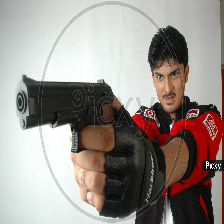

In [16]:
# Load a single image from the validation dataset
img = load_img(
    path="./data/validation/gun/testgun1.jpg", target_size=(224, 224)
)

img

Next, we need to convert this into a NumPy array, which is the format supported by Keras models as input.

In [17]:
# Convert validation image into a NumPy array
x = img_to_array(img)

x

array([[[149., 155., 153.],
        [153., 157., 156.],
        [155., 159., 158.],
        ...,
        [ 95.,  93.,  78.],
        [ 98.,  97.,  79.],
        [ 98.,  97.,  79.]],

       [[152., 156., 155.],
        [152., 156., 155.],
        [155., 159., 158.],
        ...,
        [ 99.,  98.,  80.],
        [100.,  97.,  80.],
        [ 95.,  96.,  78.]],

       [[152., 156., 155.],
        [154., 158., 157.],
        [153., 159., 157.],
        ...,
        [100.,  99.,  81.],
        [101.,  98.,  81.],
        [ 99.,  98.,  80.]],

       ...,

       [[193., 204., 200.],
        [195., 206., 202.],
        [197., 208., 204.],
        ...,
        [150., 151., 145.],
        [ 99.,  18.,   0.],
        [ 96.,  14.,   3.]],

       [[190., 200., 199.],
        [194., 204., 203.],
        [195., 206., 202.],
        ...,
        [150., 151., 145.],
        [ 99.,  18.,   0.],
        [ 96.,  12.,   1.]],

       [[191., 202., 198.],
        [192., 203., 199.],
        [195., 2

After this, we have to change the shape of the image array by **expanding its dimensions**.

Here, we convert the array from `(224, 224, 3)` to `(1, 224, 224, 3)` by adding a new dimension to the array. This new dimension is necessary to store the batch size of the inputs to be provided to the model.

For our case, we will be using a single image for validation, so we can specify a batch size of `1`.

In [18]:
# Expand dimensions of image array to accommodate for batch size
x = np.expand_dims(
    a=x,
    axis=0,
)

x

array([[[[149., 155., 153.],
         [153., 157., 156.],
         [155., 159., 158.],
         ...,
         [ 95.,  93.,  78.],
         [ 98.,  97.,  79.],
         [ 98.,  97.,  79.]],

        [[152., 156., 155.],
         [152., 156., 155.],
         [155., 159., 158.],
         ...,
         [ 99.,  98.,  80.],
         [100.,  97.,  80.],
         [ 95.,  96.,  78.]],

        [[152., 156., 155.],
         [154., 158., 157.],
         [153., 159., 157.],
         ...,
         [100.,  99.,  81.],
         [101.,  98.,  81.],
         [ 99.,  98.,  80.]],

        ...,

        [[193., 204., 200.],
         [195., 206., 202.],
         [197., 208., 204.],
         ...,
         [150., 151., 145.],
         [ 99.,  18.,   0.],
         [ 96.,  14.,   3.]],

        [[190., 200., 199.],
         [194., 204., 203.],
         [195., 206., 202.],
         ...,
         [150., 151., 145.],
         [ 99.,  18.,   0.],
         [ 96.,  12.,   1.]],

        [[191., 202., 198.],
       

Each Keras Application expects a specific kind of preprocessing done on its input before performing inference.

Thus, we must apply preprocessing steps that are, by default, required by models that are created from VGG16 in Keras Applications. For this, we use `preprocess_input()` from `keras.applications.vgg16`.

In [19]:
# Preprocess the image array as required by VGG16 from Keras Applications
img_data = preprocess_input(x)

img_data

array([[[[  49.060997,   38.221   ,   25.32    ],
         [  52.060997,   40.221   ,   29.32    ],
         [  54.060997,   42.221   ,   31.32    ],
         ...,
         [ -25.939003,  -23.779   ,  -28.68    ],
         [ -24.939003,  -19.779   ,  -25.68    ],
         [ -24.939003,  -19.779   ,  -25.68    ]],

        [[  51.060997,   39.221   ,   28.32    ],
         [  51.060997,   39.221   ,   28.32    ],
         [  54.060997,   42.221   ,   31.32    ],
         ...,
         [ -23.939003,  -18.779   ,  -24.68    ],
         [ -23.939003,  -19.779   ,  -23.68    ],
         [ -25.939003,  -20.779   ,  -28.68    ]],

        [[  51.060997,   39.221   ,   28.32    ],
         [  53.060997,   41.221   ,   30.32    ],
         [  53.060997,   42.221   ,   29.32    ],
         ...,
         [ -22.939003,  -17.779   ,  -23.68    ],
         [ -22.939003,  -18.779   ,  -22.68    ],
         [ -23.939003,  -18.779   ,  -24.68    ]],

        ...,

        [[  96.061   ,   87.221   ,   

This performs two preprocessing actions mainly:

1. Converting the input image from **RGB to BGR**.
2. Zero-centering each color channel (with respect to the ImageNet dataset), without any scaling.

Finally, we can call `Model.predict()` on the trained model to get predictions.

In [22]:
# Get prediction from the trained model on the validation image
prediction = model.predict(img_data)

print(prediction)

1/1 [==============================] - 0s 229ms/step
[[0.979829]]


To view the class predicted by the model for this image, we can check whether the value in the `prediction` tensor is greater than 0.5 (**50%**) or not.

In [23]:
# Display the prediction
if prediction > 0.5:
    print("CAUTION: Gun Detected!")
else:
    print("No Gun Detected.")

CAUTION: Gun Detected!


Since we used a validation image from the `gun` class, we can see that the model has performed accurately on this image.

### Model Saving

Finally, we can save the model to use it in practical scenarios.

In [13]:
# Save the model (to maintain model persistence)
model.save("model.h5")

/home/ravindu-aratchige/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
